Idealised 2-D mantle convection problem in a square box
=======================================================

In this tutorial, we examine an idealised 2-D problem in square box.

Governing equations
-------------------

The equations governing mantle convection are derived from the
conservation laws of mass, momentum and energy.  The simplest
mathematical formulation assumes incompressibility and the
Boussinesq approximation, under which the non–dimensional
momentum and continuity equations are given by:

$$\nabla \cdot \mathbb{\sigma} + Ra_0 \ T \ \hat{k} = 0,$$
$$\nabla \cdot \vec{u} = 0$$

where $\sigma$ is the stress tensor, $\vec{u}$ is the velocity and T
temperature. $\hat{k}$ is the unit vector in the direction opposite
to gravity and $Ra_0$ denotes the Rayleigh number, a dimensionless
number that quantifies the vigor of convection:

$$Ra0 = \frac{\rho_0 \alpha \Delta T g d^3}{\mu_0 \kappa}$$

Here, $\rho_0$ denotes reference density, $\alpha$ the thermal
expansion coefficient, $\Delta T$ the characteristic temperature
change across the domain, $g$ the gravitational acceleration, $d$
the characteristic length, $\mu_0$ the reference dynamic viscosity
and $\kappa$ the thermal diffusivity. The mantle's Rayleigh number
is estimated to be between $10^7$ and $10^9$, but we will focus on
cases at a lower convective vigor in this notebook.

When simulating incompressible flow, the full stress tensor,
$\sigma$, is decomposed into deviatoric and volumetric components:
$$ \sigma = \tau - p I,$$
where $\tau$ is the deviatoric stress tensor, $p$ is dynamic
pressure and $I$ is the identity matrix. Substituting this into the
first equation presented above and utilizing the constitutive
relation,

$$\tau = 2\mu \dot\epsilon =
  2\mu \operatorname{sym}(\nabla \vec{u}) =
  \mu\left[ \nabla \vec{u} + \left(\nabla \vec{u}\right)^T\right] $$

which relates the deviatoric stress tensor, $\tau$, to the
strain-rate tensor, $\dot\epsilon=\operatorname{sym}(\nabla
\vec{u})$, yields:

$$ \nabla \cdot \mu \left[{\nabla\vec{u}} + \left(\nabla\vec{u}\right)^T\right]
  - \nabla p + Ra_{0} T\hat{\vec{k}} = 0. $$

The viscous flow problem can thus be posed in terms of pressure,
$p$, velocity, $\vec{u}$, and temperature, $T$.

The evolution of the thermal field is controlled by an
advection-diffusion equation, where, for simplicity, we ignore
internal heating:
$$ \frac{\partial T}{\partial t} + \vec{u}\cdot \nabla T - \nabla \cdot \left(\kappa \nabla T\right) = 0 $$
These governing equations are sufficient to solve for the three
unknowns, together with adequate boundary and initial conditions.

Weak formulation
----------------

For the finite element discretisation of these equations, we start
by writing them in their weak form.  We select appropriate function
spaces V, W, and Q that contain, respectively, the solution fields
for velocity u, pressure p, and temperature T , and also contain the
test functions v, w and q. The weak form is then obtained by
multiplying these equations with the test functions and integrating
over the domain $\Omega$,

$$\int_\Omega (\nabla \vec{v})\colon \mu \left[ \nabla \vec{u} + \left( \nabla \vec{u} \right)^T\right] \ dx
 - \int_{\Omega} \left( \nabla \cdot \vec{v}\right)\ p \ dx
 - \int_{\Omega} Ra_0\ T\ \vec{v}\cdot\hat{k} \ dx = 0 \ \text{ for all } v\in V,$$

$$ \int_\Omega w \nabla \cdot \vec{u} \ dx\ \text{ for all } v\in V,$$

$$  \int_\Omega q\frac{\partial T}{\partial t} \ dx
  + \int_\Omega q \vec{u}\cdot \nabla T \ dx
  + \int_\Omega \left(\nabla q\right) \cdot \left(\kappa \nabla T\right) \ dx = 0   \text{ for all } q\in Q.$$

Note that we have integrated by parts the viscosity and pressure
gradient terms in the Stokes equations, and the diffusion term in
the energy equation, but have omitted the corresponding boundary
terms.

Solution procedure
------------------

For temporal integration, we apply a simple $\theta$ scheme to the
energy equation:

$$
  F_{\text{energy}}(q; T^{n+1}) :=
    \int_\Omega q \frac{T^{n+1} - T^n}{\Delta t} dx
  + \int_\Omega q\vec{u}\cdot\nabla T^{n+\theta} dx
  + \int_\Omega \left(\nabla q\right)\cdot \left(\kappa \nabla
  T^{n+\theta}\right) dx = 0
  \text{ for all } q\in Q,
$$

where
$$
  T^{n+\theta} = \theta T^{n+1} + (1-\theta) T^n
$$

is interpolated between the temperature solutions $T^n$ and
$T^{n+1}$ at the beginning and end of the $n+1$-th time step using a
parameter $0\leq\theta\leq 1$.  In this example we use an
implicit mid-point scheme, where $\theta = 0.5$.

To simplify we will solve for velocity and pressure, $\vec{u}$ and
$p$, in a separate step before solving for temperature
$T$. Since these weak equations need to hold for all test
functions $\vec{v}\in V$ and $w\in W$ we can equivalently write,
using a single residual functional $F_{\text{Stokes}}$:

$$
  F_{\text{Stokes}}(\vec{v},w; \vec{u}, p) =
    \int_\Omega \left(\nabla \vec{v}\right) \colon \mu \left[{\nabla\vec{u}}
    + \left(\nabla\vec{u}\right)^T\right] dx
  - \int_\Omega \left(\nabla\cdot \vec{v}\right) p dx \\
  - \int_\Omega Ra_{0} T\vec{v}\cdot\hat{\vec{k}} dx
  - \int_\Omega w \nabla \cdot \vec{u} dx = 0
  \text{ for all } \vec{v}\in V,
  w\in W,
$$

where we have multiplied the continuity equation with $-1$ to ensure
symmetry between the $\nabla p$ and $\nabla\cdot u$ terms. This
combined weak form that we simultaneously solve for a velocity $u\in
V$ and pressure $p\in W$ is referred to as a mixed problem, and the
combined solution $(\vec{u}, p)$ is said to be found in the mixed function
space $V\oplus W$.

This example
------------

Firedrake provides a complete framework for solving finite element
problems, highlighted herein with the most
basic mantle dynamics problem - isoviscous, incompressible
convection, heated from below (T=1), cooled from the top (T=0) in an
enclosed 2-D Cartesian box (i.e. free-slip mechanical boundary
conditions on all boundaries), from Blankenbach et al. (1989).

Let's get started! The first step is to import the gadopt module, which
provides access to Firedrake and associated functionality.

In [1]:
from gadopt import *

We will set up the problem using a bilinear quadrilateral element
pair (Q2-Q1) for velocity and pressure, with Q2 elements for
temperature.

We first need a mesh: for simple domains such as the unit square,
Firedrake provides built-in meshing functions. As such, the
following code defines the mesh, with 40 quadrilateral elements in x
and y directions. We also tag boundary IDs.  Boundaries are
automatically tagged by the built-in meshes supported by
Firedrake. For the `UnitSquareMesh` being used here, tag 1
corresponds to the plane $x=0$; 2 to the $x=1$ plane; 3 to the $y=0$ plane;
and 4 to the $y=1$ plane. We name these `left`, `right`, `bottom` and `top`,
respectively.

On the mesh, we also denote that our geometry is Cartesian, i.e. gravity points
in the negative z-direction. This attribute is used by gadopt specifically, not
Firedrake. By contrast, a non-Cartesian geometry is assumed to have gravity
pointing in the radially inward direction.

In [2]:
nx, ny = 40, 40  # Number of cells in x and y directions.
mesh = UnitSquareMesh(nx, ny, quadrilateral=True)  # Square mesh generated via firedrake
mesh.cartesian = True
left_id, right_id, bottom_id, top_id = 1, 2, 3, 4  # Boundary IDs

We also need function spaces, which is achieved by associating the
mesh with the relevant finite element: V , W and Q are symbolic
variables representing function spaces. They also contain the
function space’s computational implementation, recording the
association of degrees of freedom with the mesh and pointing to the
finite element basis.

In [3]:
V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)

Function spaces can be combined in the natural way to create mixed
function spaces, combining the velocity and pressure spaces to form
a function space for the mixed Stokes problem, Z.

In [4]:
Z = MixedFunctionSpace([V, W])  # Mixed function space.

We also specify functions to hold our solutions: z in the mixed
function space, noting that a symbolic representation of the two
parts – velocity and pressure – is obtained with `split`. For later
visualisation, we rename the subfunctions of z Velocity and Pressure.

In [5]:
z = Function(Z)  # A field over the mixed function space Z.
u, p = split(z)  # Returns symbolic UFL expression for u and p
z.subfunctions[0].rename("Velocity")
z.subfunctions[1].rename("Pressure")

We can output function space information, for example the number of degrees
of freedom (DOF) using log, a utility provided by gadopt.

In [6]:
log("Number of Velocity DOF:", V.dim())
log("Number of Pressure DOF:", W.dim())
log("Number of Velocity and Pressure DOF:", V.dim()+W.dim())
log("Number of Temperature DOF:", Q.dim())

Number of Velocity DOF: 13122
Number of Pressure DOF: 1681
Number of Velocity and Pressure DOF: 14803
Number of Temperature DOF: 6561


The Rayleigh number for this problem is defined. The viscosity and thermal
diffusivity are left at their default values (both = 1). We note that viscosity
could also be a Function, if we wanted spatial variation, and will
return to this in a subsequent notebook.  These Ra is required to
create an *Approximation* representing the physical
setup of the problem (options include Boussinesq, Extended
Boussinesq, Truncated Anelastic Liquid and Anelastic Liquid), and a
*Timestep Adaptor*, for controlling the time-step length (via a CFL
criterion) as the simulation advances in time. For the latter,
we specify the initial time, initial timestep $\Delta t$, and number of
timesteps. Given the low Ra, a steady-state tolerance is also specified,
allowing the simulation to exit when a steady-state has been achieved.

In [7]:
Ra = Constant(1e4)  # Rayleigh number
approximation = BoussinesqApproximation(Ra)

time = 0.0  # Initial time
delta_t = Constant(1e-6)  # Initial time-step
timesteps = 20000  # Maximum number of timesteps
t_adapt = TimestepAdaptor(delta_t, u, V, maximum_timestep=0.1, increase_tolerance=1.5)

steady_state_tolerance = 1e-9  # Used to determine if solution has reached a steady state.

Mantle convection is an initial and boundary-value problem. We
assume the initial temperature distribution to be prescribed by

$T(x,y) = (1-y) + 0.05\ cos(\pi x)\ sin(\pi y)$

In the following code, we first obtain symbolic expressions for
coordinates in the physical mesh and subsequently use these to
initialize the temperature field.  This is where Firedrake
transforms a symbolic operation into a numerical computation for the
first time: the `interpolate` method generates C code that evaluates
this expression at the nodes of $T$.

In [8]:
X = SpatialCoordinate(mesh)
T = Function(Q, name="Temperature")
T.interpolate((1.0-X[1]) + (0.05*cos(pi*X[0])*sin(pi*X[1])))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x7449a78f6d20>, FiniteElement('Q', quadrilateral, 2), name=None), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), dim=2), 0)), 13)

We can visualise the initial temperature field using Firedrake's
built-in plotting functionality.

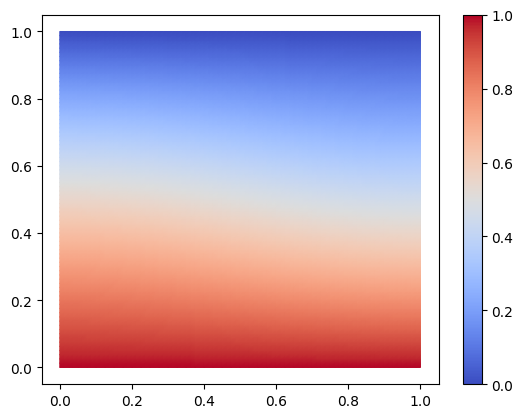

In [9]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots()
collection = tripcolor(T, axes=axes, cmap='coolwarm')
fig.colorbar(collection);

With closed boundaries, and no constraint on pressure anywhere in
the domain, this problem has a constant pressure nullspace and we
must ensure that our solver removes this space. To do so, we build a
nullspace object, which will subsequently be passed to the solver,
and PETSc will seek a solution in the space orthogonal to the
provided nullspace.  When building the nullspace object, the
'closed' keyword handles the constant pressure nullspace, whilst the
'rotational' keyword deals with rotational modes, which, for
example, manifest in an a annulus domain with free slip top and
bottom boundaries (as we will see in a later tutorial).

In [10]:
Z_nullspace = create_stokes_nullspace(Z, closed=True, rotational=False)

We next specify strong Dirichlet boundary conditions for velocity and
temperature. The user must provide the part of the mesh at which
each boundary condition applies.  Note how boundary conditions have
the granularity to be applied to the $x$ and $y$ components of the
velocity field only, if desired.

In [11]:
stokes_bcs = {
    bottom_id: {'uy': 0},
    top_id: {'uy': 0},
    left_id: {'ux': 0},
    right_id: {'ux': 0},
}

temp_bcs = {
    bottom_id: {'T': 1.0},
    top_id: {'T': 0.0},
}

We next set up our output, in VTK format. To do so, we create the output file
and specify the output_frequency in timesteps.

In [12]:
output_file = VTKFile("output.pvd")
output_frequency = 50

Next, we open a file for logging diagnostic output and provide the header. We will be outputting
the timestep number, the time, the timestep size, the L2 norm of the change in temperature between
consequtive timesteps, the RMS velocity, the RMS velocity at the surface of the domain, the maximum
x-component of velocity at the domains surface, the surface Nusselt number, the basal Nusselt number,
the difference between surface and bottom Nusselt numbers (energy_conservation) and the average temperature
across the domain. These are computed using the GeodynamicalDiagnostics class, which takes in the Stokes (z)
and temperature functions, alongside bottom and top boundary IDs.

In [13]:
plog = ParameterLog('params.log', mesh)
plog.log_str("timestep time dt maxchange u_rms u_rms_surf ux_max nu_top nu_base energy avg_t")

gd = GeodynamicalDiagnostics(z, T, bottom_id, top_id)

We finally come to solving the variational problem, with solver
objects for the energy and Stokes systems created. For the energy
system we pass in the solution field T, velocity u, the physical
approximation, time step, temporal discretisation approach
(i.e. implicit middle point), and temperature boundary conditions. For the Stokes
system, we pass in the solution fields z, Temperature, the physical
approximation, boundary conditions and the nullspace object.

Given that this model is isoviscous, we can speed up the simulation by specifying a
constant Jacobian (preventing uneccesary matrix re-assembly).
We note that solution of the two variational problems is undertaken by PETSc.

In [14]:
energy_solver = EnergySolver(T, u, approximation, delta_t, ImplicitMidpoint, bcs=temp_bcs)

stokes_solver = StokesSolver(z, T, approximation, bcs=stokes_bcs,
                             nullspace=Z_nullspace, transpose_nullspace=Z_nullspace,
                             constant_jacobian=True)

We can now initiate the time-loop, with the Stokes and energy
systems solved seperately. These `solve` calls once again convert
symbolic mathematics into computation. In the time loop, set here to
run for a maximum of 20000 time-steps, we output in VTK format every 50 timesteps.
The timestep itself is updated, using the update_timestep function, with diagnostics logged via the log utility
at every timestep. At the end of each time step, we calculate the L2-norm of
the change in temperature and, once this drops below the steady_state_tolerance specified above,
we exit the timeloop.

In [15]:
for timestep in range(0, timesteps):

    # Write output:
    if timestep % output_frequency == 0:
        output_file.write(*z.subfunctions, T)

    dt = t_adapt.update_timestep()
    time += dt

    # Solve Stokes sytem:
    stokes_solver.solve()

    # Temperature system:
    energy_solver.solve()

    # Compute diagnostics:
    energy_conservation = abs(abs(gd.Nu_top()) - abs(gd.Nu_bottom()))

    # Calculate L2-norm of change in temperature:
    maxchange = sqrt(assemble((T - energy_solver.T_old)**2 * dx))

    # Log diagnostics:
    plog.log_str(f"{timestep} {time} {float(delta_t)} {maxchange} "
                 f"{gd.u_rms()} {gd.u_rms_top()} {gd.ux_max(top_id)} {gd.Nu_top()} "
                 f"{gd.Nu_bottom()} {energy_conservation} {gd.T_avg()} ")

    # Leave if steady-state has been achieved:
    if maxchange < steady_state_tolerance:
        log("Steady-state achieved -- exiting time-step loop")
        break

Steady-state achieved -- exiting time-step loop


At the end of the simulation, once a steady-state has been achieved, we close our logging file
and checkpoint steady state temperature and Stokes solution fields to disk. These can later be
used to restart a simulation, if required.

In [16]:
plog.close()

with CheckpointFile("Final_State.h5", "w") as final_checkpoint:
    final_checkpoint.save_mesh(mesh)
    final_checkpoint.save_function(T, name="Temperature")
    final_checkpoint.save_function(z, name="Stokes")

We can visualise the final temperature field using Firedrake's
built-in plotting functionality.

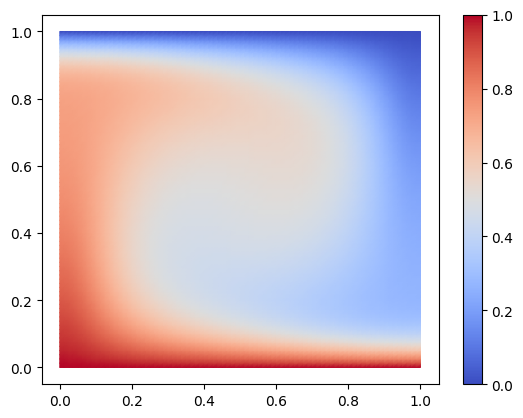

In [17]:
fig, axes = plt.subplots()
collection = tripcolor(T, axes=axes, cmap='coolwarm')
fig.colorbar(collection);